In [1]:
from matplotlib import pyplot as plt
from torch import optim
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch
from gensim.models import KeyedVectors
import numpy as np
import string
from collections import defaultdict
import pandas as pd
from importnb import imports
with imports ("ipynb"):
    import  knock84 as k84

UPDATE 3-Big US banks' funding advantage reduced, could rise in crisis-official
[4, 0, 7, 0, 3046, 5175, 0, 175, 123, 3, 0]
学習済単語数: 16412 / 17157
torch.Size([17157, 300])


###  双方向RNN
通常のTNNだと，過去から未来への1方向でしか学習をすることができない．     
そこで，RNNを2つ組み合わせることで，双方向から学習できるようにしたモデルが双方向RNN．

In [9]:
make_and_translate_ID = k84.make_and_translate_ID

#全ての句読点文字をスペースに置き換える翻訳テーブル
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
header_name = ['TITLE', 'CATEGORY']
train_data = pd.read_csv("../chapter06/train.txt", header=None,sep='\t', names=header_name)

w2id = make_and_translate_ID(train_data["TITLE"])
test_vec = w2id.return_id(train_data["TITLE"][10])
print(train_data["TITLE"][10])
print(test_vec)

UPDATE 3-Big US banks' funding advantage reduced, could rise in crisis-official
[4, 0, 7, 0, 3046, 5175, 0, 175, 123, 3, 0]


In [10]:
file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
file_name = "../chapter07/GoogleNews-vectors-negative300.bin.gz"
model = KeyedVectors.load_word2vec_format(file_name, binary=True)

VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))#lenがVOCAB_SIZEの，EMB_SIZE個ずつ0が入っている配列
words_in_pretrained = 0

# 与えられた単語に対し，学習済モデルから単語埋め込み(=ベクトル)を取得する
for i, word in enumerate(w2id.id_dict.keys()):
    #i:単語ID，　word:単語
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:#キーがなければランダムなベクトルを生成
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))

weights = torch.from_numpy(weights.astype((np.float32)))#torch.from_numpy: ndarrayからtensorを作る
print(f'学習済単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済単語数: 16412 / 17157
torch.Size([17157, 300])


In [18]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
        super().__init__()
        self.hid_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        
        if emb_weight != None:
            self.emb = nn.Embedding.from_pretrained(
                emb_weight, padding_idx=pad_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)

        self.rnn = nn.RNN(emb_size, hidden_size, num_layers,
                          nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(self.num_layers * self.num_directions,
                             self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        return torch.zeros(self.num_layers * num_directions, batch_size, self.hid_size).to(self.device)

In [19]:
#RNN = k84.RNN
NewsDataset = k84.NewsDataset
calc_loss_and_acc = k84.calc_loss_and_acc
make_graph_by_logs = k84.make_graph_by_logs
Padseq = k84.Padseq

train = pd.read_csv("../chapter06/train.txt", sep='\t')
valid = pd.read_csv("../chapter06/valid.txt", sep='\t')
test = pd.read_csv("../chapter06/test.txt", sep='\t')

category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)

In [20]:
# knock82より
# 学習する
def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_and_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_and_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'./k85_saves/checkpoint{epoch + 1}.pt')

        print(f"epoch: {epoch+1},"
        f"loss_train: {loss_train:.4f},"
        f"accuracy_train: {acc_train:.4f},"
        f"loss_valid: {loss_valid:.4f},"
        f"accuracy_valid: {acc_valid:.4f},"
        f"train_time: {(end_time - start_time):.4f}sec")
    return {
        "train": log_train,
        "valid": log_valid
    }

/Users/shirakawamomoko/Desktop/nlp100保存/chapter09/knock84.ipynb:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1,loss_train: 1.3620,accuracy_train: 0.4115,loss_valid: 1.3894,accuracy_valid: 0.4190,train_time: 11.0424sec
epoch: 2,loss_train: 1.3210,accuracy_train: 0.4097,loss_valid: 1.3395,accuracy_valid: 0.4108,train_time: 10.6518sec
epoch: 3,loss_train: 1.1727,accuracy_train: 0.5226,loss_valid: 1.1930,accuracy_valid: 0.5195,train_time: 10.0098sec
epoch: 4,loss_train: 1.2646,accuracy_train: 0.5015,loss_valid: 1.3211,accuracy_valid: 0.4850,train_time: 10.0357sec
epoch: 5,loss_train: 1.1269,accuracy_train: 0.5808,loss_valid: 1.1762,accuracy_valid: 0.5630,train_time: 10.6424sec
epoch: 6,loss_train: 1.3658,accuracy_train: 0.4954,loss_valid: 1.4450,accuracy_valid: 0.4813,train_time: 10.0162sec
epoch: 7,loss_train: 1.0284,accuracy_train: 0.6319,loss_valid: 1.0751,accuracy_valid: 0.6169,train_time: 10.0509sec
epoch: 8,loss_train: 1.0772,accuracy_train: 0.6070,loss_valid: 1.1415,accuracy_valid: 0.5982,train_time: 9.8596sec
epoch: 9,loss_train: 1.0133,accuracy_train: 0.6405,loss_valid: 1.0766,acc

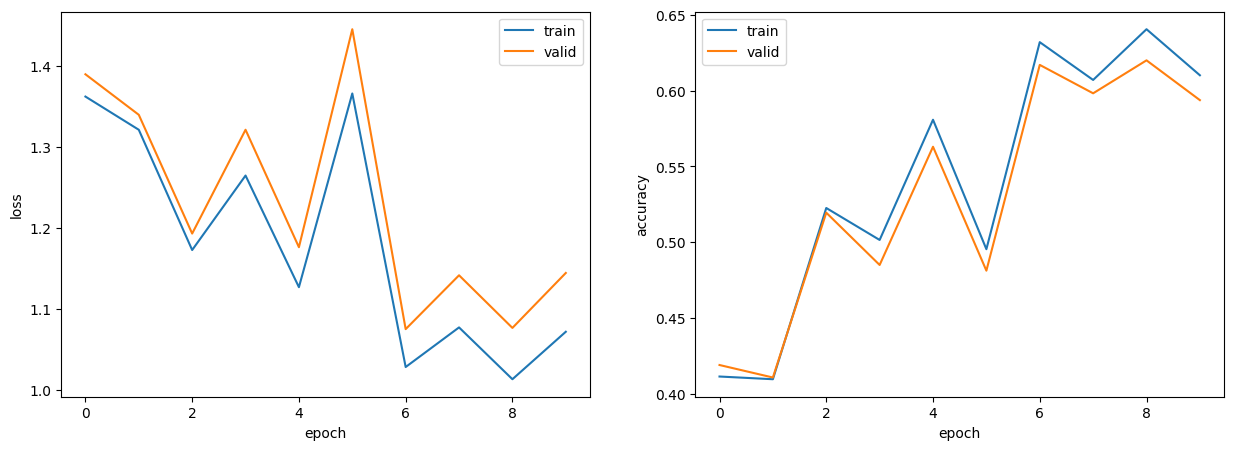

In [21]:
if __name__ == "__main__":
    VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
    EMB_SIZE = 300
    PADDING_IDX = len(set(w2id.id_dict.values()))
    OUTPUT_SIZE = 4
    HIDDEN_SIZE = 50
    NUM_LAYERS = 2#RNNを重ねる数．今回は双方向なので2
    LEARNING_RATE = 5e-2
    BATCH_SIZE = 32
    NUM_EPOCHS = 10

    device = torch.device("mps")

    #bidirectional=Trueで双方向RNNに指定する．デフォルトはFalse.
    #https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, 
                OUTPUT_SIZE, device, NUM_LAYERS, emb_weight=weights, bidirectional=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                    optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))
    
    make_graph_by_logs(log, "./graphs/knock85.png")

    # 損失と精度の計算
    _, acc_train = calc_loss_and_acc(model, dataset_train, device)
    _, acc_test = calc_loss_and_acc(model, dataset_test, device)

    print(f'Train Accuracy: {acc_train:.3f}')
    print(f'Test Accuracy: {acc_test:.3f}')
